<a href="https://colab.research.google.com/github/pranavsouri/LSTM/blob/main/Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Anomaly Detection in Time Series with Keras


## Task 1: Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [ ]:
df = pd.read_csv('amCharts Google Collab Stocks.csv', parse_dates=['date'])
df = df.dropna()

df.head()

,date,close
0,2019-07-02,38.88
1,2019-07-03,38.61
2,2019-07-04,38.41
3,2019-07-05,36.79
4,2019-07-06,38.89


In [ ]:
df.shape

(1093, 2)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(874, 2) (219, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(844, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [ ]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

## Task 6: Train the Autoencoder

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
24/24 [==============================] - 3s 37ms/step - loss: 0.4296 - val_loss: 0.3490
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.2757
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 0.1933 - val_loss: 0.2714
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1838 - val_loss: 0.2752
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.2002 - val_loss: 0.2530
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1849 - val_loss: 0.2608
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1906 - val_loss: 0.2527
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1853 - val_loss: 0.2552
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 0.1903 - val_loss: 0.2441
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1883 - val_loss: 0.2442
Ep

## Task 7: Plot Metrics and Evaluate the Model

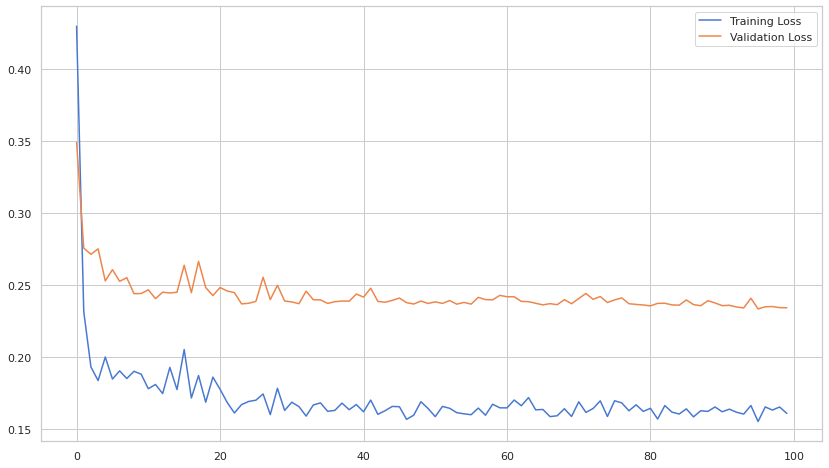

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 5ms/step - loss: 0.3530


0.35297268629074097

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



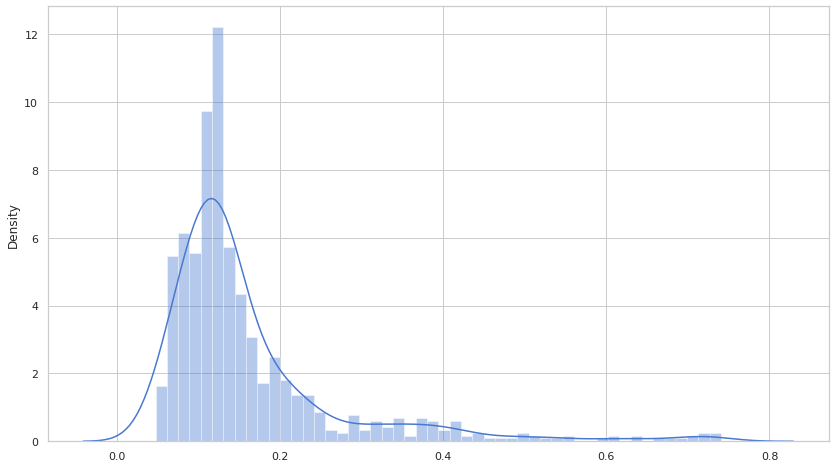

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



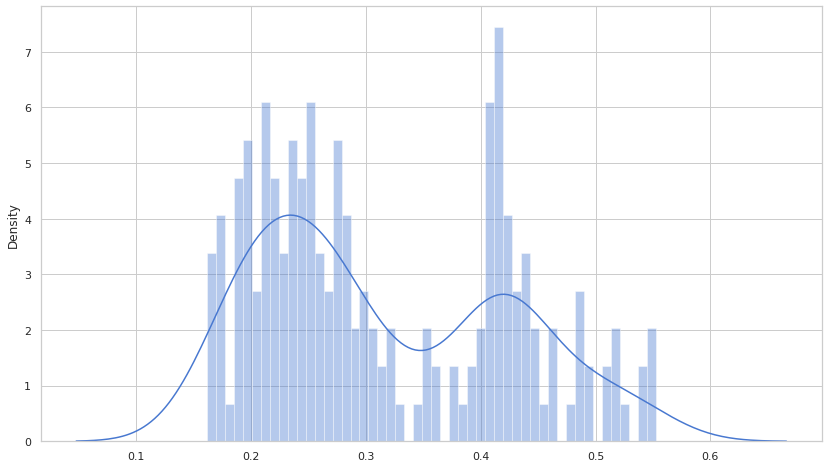

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [ ]:
THRESHOLD = train_mae_loss.max()

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test[time_steps:].close,
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=anomalies.close,
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()